### Monte Carlo for convergencse check of ACO and GA algorithms

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [2]:
def monte_carlo_convergence_analysis(base_dir, name_dir):
    """
    This script analyzes the convergence of Monte Carlo simulations by plotting the best values found
    across multiple runs and displaying summary statistics.
    """
    BASE_DIR = base_dir
    NAME_DIR = name_dir
    
    absolute_bests_print = True
    confidense_interval_print = True
    highlight_best_path = True


    folders = sorted([f for f in os.listdir(BASE_DIR) if f.startswith(NAME_DIR)])

    # Set maximum number of iterations to use from each file
    MAX_ITERATIONS = 1000  # Change this to your desired number

    # Set global matplotlib parameters
    plt.rcParams['axes.labelsize'] = 16      # x and y axis labels
    plt.rcParams['xtick.labelsize'] = 14     # x-axis tick labels
    plt.rcParams['ytick.labelsize'] = 14     # y-axis tick labels
    plt.rcParams['legend.fontsize'] = 11     # legend font size


    # For collecting all best values per simulation
    all_best_values = []
    start_values = []
    end_values = []
    absolute_bests = []
    best_run_index = None
    best_run_values = None

    fig, ax = plt.subplots(1, 1, figsize=(12, 7))

    # Track successful loads
    successful_runs = 0

    for folder in folders:
        path = os.path.join(BASE_DIR, folder)
        try:
            stats_path = os.path.join(path, "statistics.npy")
            stats = np.load(stats_path, allow_pickle=True).item()
            #line to print headers of stats
            #print(f"Keys in stats: {list(stats.keys())}")
            
            best_values = np.array(stats["best"])
            
            # Truncate to maximum iterations
            if len(best_values) > MAX_ITERATIONS:
                best_values = best_values[:MAX_ITERATIONS]
            
            absolute_best = stats["absolute_best"]
            
            # Handle different formats of absolute_best
            if isinstance(absolute_best, (list, tuple, np.ndarray)):
                abs_best_value = absolute_best[-1] if len(absolute_best) > 2 else absolute_best[0]
            else:
                abs_best_value = absolute_best

            start_values.append(best_values[0])
            end_values.append(best_values[-1])
            absolute_bests.append(abs_best_value)
            all_best_values.append(best_values)
            
            # Track the best run for highlighting
            if best_run_index is None or abs_best_value < absolute_bests[best_run_index]:
                best_run_index = successful_runs
                best_run_values = best_values.copy()

            # Plot convergence curve
            ax.plot(best_values, color="tomato", alpha=0.3, linewidth=1.5, zorder=1)
            successful_runs += 1
            
        except Exception as e:
            print(f"Could not load stats from {path}: {e}")
            
    # Highlight the best path if option is enabled
    if highlight_best_path is not None:
        ax.plot(best_run_values, color="darkred", alpha=0.5, linewidth=2, zorder=1, label=f"Best run")
        
    # Find the maximum number of iterations across all runs (after truncation)
    max_iterations = max(len(run) for run in all_best_values) if all_best_values else 0

    # Only plot markers if we have data
    if start_values and end_values:
        # Plot start and end markers for all runs
        iterations = range(len(start_values))
        ax.scatter(np.zeros(len(start_values)), start_values, 
                color='green', s=50, alpha=0.7, label=f"Start point")
        
        # For end values, use the actual final iteration index
        if all_best_values:
            final_iterations = [len(run) - 1 for run in all_best_values]
            ax.scatter(final_iterations, end_values, 
                    color='red', s=50, alpha=0.7, label=f"End point")

    # Plot reference lines
    if absolute_bests:
        min_abs_best = min(absolute_bests)
        max_abs_best = max(absolute_bests)
        mean_abs_best = np.mean(absolute_bests)
        
        ax.axhline(min_abs_best, linestyle='-', color='black', linewidth=2, 
                label=f"Best overall: {min_abs_best:.0f}", zorder=2)
        ax.axhline(mean_abs_best, linestyle='--', color='gray', alpha=0.7,
                label=f"Mean best: {mean_abs_best:.0f}", zorder=2)


    # Improve plot aesthetics
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Latency [cycles]")
    #ax.set_ylim(0, 8000)
    #ax.set_title(f"ACO Convergence Analysis ({successful_runs} runs)", fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

    # Add statistics text box
    if absolute_bests_print:
        stats_text = f"Runs: {successful_runs}\nBest: {min_abs_best:.0f}\nWorst: {max_abs_best:.0f}\nMean: {mean_abs_best:.1f}\nStd: {np.std(absolute_bests):.1f}"
        ax.text(0.02, 0.02, stats_text, transform=ax.transAxes,
            verticalalignment='bottom', horizontalalignment='left', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        ax.legend(loc='best')
        
    if confidense_interval_print:
        # Pad sequences to same length for percentile calculation
        max_len = max(len(run) for run in all_best_values)
        padded_runs = []
        for run in all_best_values:
            padded = np.full(max_len, run[-1])  # Pad with final value
            padded[:len(run)] = run
            padded_runs.append(padded)
        
        runs_array = np.array(padded_runs)
        percentile_25 = np.percentile(runs_array, 25, axis=0)
        percentile_75 = np.percentile(runs_array, 75, axis=0)
        median = np.percentile(runs_array, 50, axis=0)
        
        iterations = np.arange(max_len)
        ax.fill_between(iterations, percentile_25, percentile_75, 
                        alpha=0.2, color='blue', label='25th-75th percentile', zorder=2)
        ax.plot(median, color='blue', linewidth=2, label='Median', zorder=2)
        ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    if absolute_bests:
        print(f"\n=== Summary Statistics ===")
        print(f"Successful runs: {successful_runs}")
        print(f"Maximum iterations used: {max_iterations}")
        print(f"Truncated to: {MAX_ITERATIONS} iterations")
        print(f"Best latency found: {min_abs_best:.0f} cycles")
        print(f"Worst latency: {max_abs_best:.0f} cycles")
        print(f"Mean latency: {mean_abs_best:.1f} cycles")
        print(f"Standard deviation: {np.std(absolute_bests):.1f} cycles")
        print(f"Improvement range: {max_abs_best - min_abs_best:.0f} cycles")

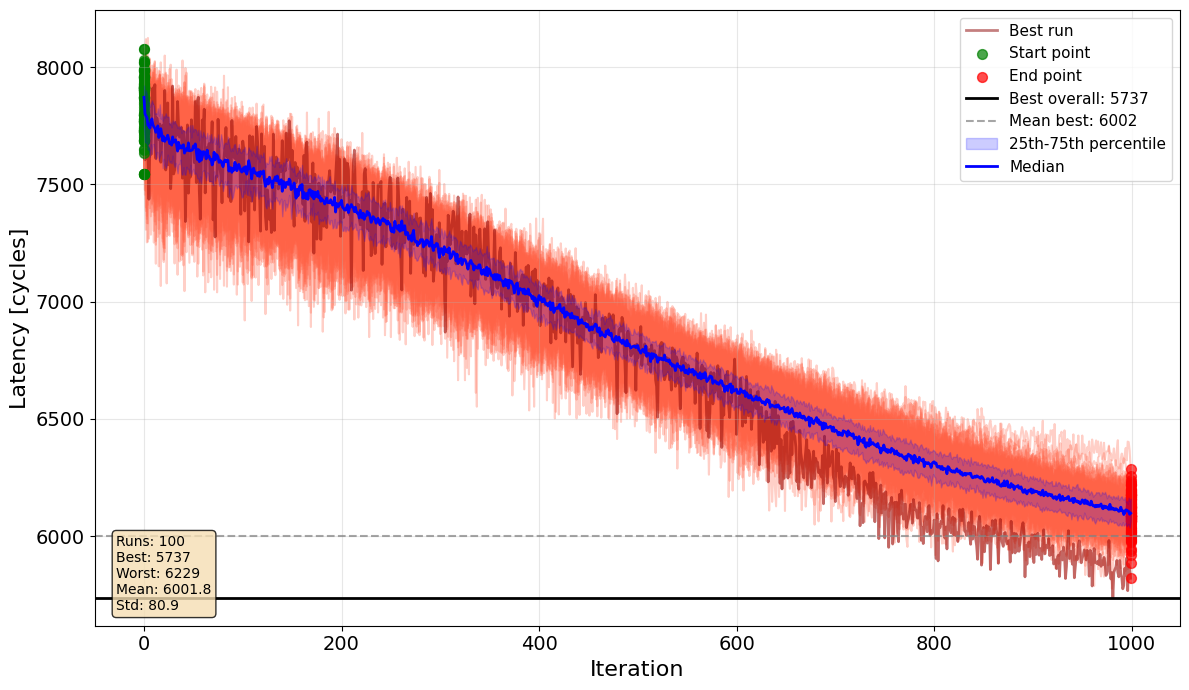


=== Summary Statistics ===
Successful runs: 100
Maximum iterations used: 1000
Truncated to: 1000 iterations
Best latency found: 5737 cycles
Worst latency: 6229 cycles
Mean latency: 6001.8 cycles
Standard deviation: 80.9 cycles
Improvement range: 492 cycles


In [3]:
#ACO MC LeNet 1k
BASE_DIR = "../data/ACO_run_array_LeNet_1k_MC" 
NAME_DIR = "ACO_LeNet4"
monte_carlo_convergence_analysis(BASE_DIR, NAME_DIR)

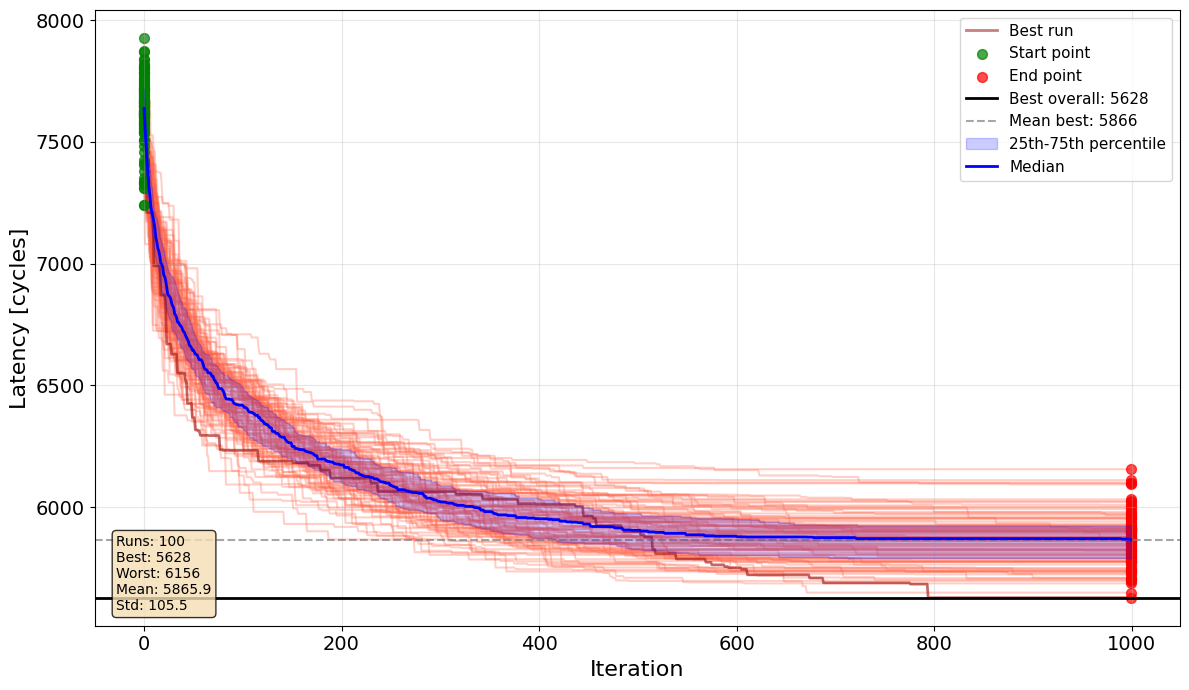


=== Summary Statistics ===
Successful runs: 100
Maximum iterations used: 1000
Truncated to: 1000 iterations
Best latency found: 5628 cycles
Worst latency: 6156 cycles
Mean latency: 5865.9 cycles
Standard deviation: 105.5 cycles
Improvement range: 528 cycles


In [4]:
#GA MC LeNet 1k it
BASE_DIR = "../data/GA_run_array_1k_sss_MC" 
NAME_DIR = "GA_LeNet4"
monte_carlo_convergence_analysis(BASE_DIR, NAME_DIR)

In [17]:
def plot_start_end_distribution(start_values, end_values):
    """
    Plot the distribution of start and end values from Monte Carlo simulations.
    
    Parameters:
    start_values (list): List of starting values from each simulation run
    end_values (list): List of ending values from each simulation run
    """
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Histogram comparison
    ax1 = plt.subplot(2, 3, 1)
    bins = 30
    alpha = 0.7
    
    plt.hist(start_values, bins=bins, alpha=alpha, color='green', 
             label=f'Start values (n={len(start_values)})', density=True)
    plt.hist(end_values, bins=bins, alpha=alpha, color='red', 
             label=f'End values (n={len(end_values)})', density=True)
    
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Distribution Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Box plot comparison
    ax2 = plt.subplot(2, 3, 2)
    data_to_plot = [start_values, end_values]
    labels = ['Start', 'End']
    colors = ['green', 'red']
    
    bp = plt.boxplot(data_to_plot, labels=labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.ylabel('Value')
    plt.title('Box Plot Comparison')
    plt.grid(True, alpha=0.3)
    
    # 3. Violin plot
    ax3 = plt.subplot(2, 3, 3)
    parts = plt.violinplot([start_values, end_values], positions=[1, 2])
    
    colors = ['green', 'red']
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    plt.xticks([1, 2], ['Start', 'End'])
    plt.ylabel('Value')
    plt.title('Violin Plot Comparison')
    plt.grid(True, alpha=0.3)
    
    # 4. Improvement scatter plot
    ax4 = plt.subplot(2, 3, 4)
    improvements = np.array(end_values) - np.array(start_values)
    
    plt.scatter(start_values, end_values, alpha=0.6, color='blue', s=50)
    
    # Add diagonal line (no improvement line)
    min_val = min(min(start_values), min(end_values))
    max_val = max(max(start_values), max(end_values))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, 
             label='No improvement')
    
    plt.xlabel('Start Value')
    plt.ylabel('End Value')
    plt.title('Start vs End Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Improvement distribution
    ax5 = plt.subplot(2, 3, 5)
    plt.hist(improvements, bins=20, alpha=0.7, color='purple', density=True)
    plt.axvline(0, color='black', linestyle='--', alpha=0.5, label='No improvement')
    plt.axvline(np.mean(improvements), color='orange', linestyle='-', 
                label=f'Mean: {np.mean(improvements):.3f}')
    
    plt.xlabel('Improvement (End - Start)')
    plt.ylabel('Density')
    plt.title('Improvement Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Q-Q plot for normality check
    ax6 = plt.subplot(2, 3, 6)
    stats.probplot(improvements, dist="norm", plot=plt)
    plt.title('Q-Q Plot (Improvements)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Print summary statistics
    print("=== DISTRIBUTION SUMMARY ===")
    print(f"\nStart Values:")
    print(f"  Mean: {np.mean(start_values):.4f}")
    print(f"  Std:  {np.std(start_values):.4f}")
    print(f"  Min:  {np.min(start_values):.4f}")
    print(f"  Max:  {np.max(start_values):.4f}")
    
    print(f"\nEnd Values:")
    print(f"  Mean: {np.mean(end_values):.4f}")
    print(f"  Std:  {np.std(end_values):.4f}")
    print(f"  Min:  {np.min(end_values):.4f}")
    print(f"  Max:  {np.max(end_values):.4f}")
    
    print(f"\nImprovements (End - Start):")
    print(f"  Mean: {np.mean(improvements):.4f}")
    print(f"  Std:  {np.std(improvements):.4f}")
    print(f"  Median: {np.median(improvements):.4f}")
    print(f"  Runs improved: {np.sum(improvements < 0)} / {len(improvements)} ({100*np.sum(improvements < 0)/len(improvements):.1f}%)")
    
    # Statistical tests
    print(f"\n=== STATISTICAL TESTS ===")
    
    # Paired t-test
    t_stat, p_value = stats.ttest_rel(end_values, start_values)
    print(f"Paired t-test (End vs Start):")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.6f}")
    
    # Wilcoxon signed-rank test (non-parametric alternative)
    w_stat, w_p_value = stats.wilcoxon(end_values, start_values, alternative='less')
    print(f"Wilcoxon signed-rank test:")
    print(f"  statistic: {w_stat:.4f}")
    print(f"  p-value: {w_p_value:.6f}")
    
    # Normality test for improvements
    shapiro_stat, shapiro_p = stats.shapiro(improvements)
    print(f"Shapiro-Wilk test (normality of improvements):")
    print(f"  statistic: {shapiro_stat:.4f}")
    print(f"  p-value: {shapiro_p:.6f}")


In [18]:
def extract_start_end_values(base_dir, name_dir, max_iterations=1000):
    """
    Extract start and end values from Monte Carlo simulation results.
    
    Parameters:
    -----------
    base_dir : str
        Base directory containing simulation folders
    name_dir : str
        Prefix of folder names to process
    max_iterations : int, optional
        Maximum number of iterations to consider from each run (default: 1000)
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'start_values': list of starting values for each run
        - 'end_values': list of ending values for each run
        - 'absolute_bests': list of absolute best values for each run
        - 'all_best_values': list of arrays containing all best values per run
        - 'successful_runs': number of successfully loaded runs
        - 'failed_runs': list of folders that failed to load
    """
    
    # Get sorted list of folders
    folders = sorted([f for f in os.listdir(base_dir) if f.startswith(name_dir)])
    
    # Initialize containers
    start_values = []
    end_values = []
    absolute_bests = []
    all_best_values = []
    failed_runs = []
    successful_runs = 0
    
    print(f"Processing {len(folders)} folders...")
    
    for i, folder in enumerate(folders):
        path = os.path.join(base_dir, folder)
        
        try:
            # Load statistics file
            stats_path = os.path.join(path, "statistics.npy")
            stats = np.load(stats_path, allow_pickle=True).item()
            
            # Extract best values array
            best_values = np.array(stats["best"])
            
            # Truncate to maximum iterations if necessary
            if len(best_values) > max_iterations:
                best_values = best_values[:max_iterations]
            
            # Extract absolute best value
            absolute_best = stats["absolute_best"]
            
            # Handle different formats of absolute_best
            if isinstance(absolute_best, (list, tuple, np.ndarray)):
                abs_best_value = absolute_best[-1] if len(absolute_best) > 2 else absolute_best[0]
            else:
                abs_best_value = absolute_best
            
            # Store values
            start_values.append(best_values[0])
            end_values.append(best_values[-1])
            absolute_bests.append(abs_best_value)
            all_best_values.append(best_values)
            
            successful_runs += 1
            
            # Progress indicator
            if (i + 1) % 10 == 0 or (i + 1) == len(folders):
                print(f"  Processed {i + 1}/{len(folders)} folders ({successful_runs} successful)")
            
        except Exception as e:
            print(f"  Failed to load {folder}: {e}")
            failed_runs.append(folder)
    
    # Create results dictionary
    results = {
        'start_values': start_values,
        'end_values': end_values,
        'absolute_bests': absolute_bests,
        'all_best_values': all_best_values,
        'successful_runs': successful_runs,
        'failed_runs': failed_runs,
        'max_iterations_used': max_iterations
    }
    
    # Print summary
    print(f"\n=== Extraction Summary ===")
    print(f"Total folders found: {len(folders)}")
    print(f"Successfully loaded: {successful_runs}")
    print(f"Failed to load: {len(failed_runs)}")
    if failed_runs:
        print(f"Failed folders: {failed_runs}")
    
    if start_values:
        print(f"\nData Summary:")
        print(f"Start values range: {min(start_values):.2f} - {max(start_values):.2f}")
        print(f"End values range: {min(end_values):.2f} - {max(end_values):.2f}")
        print(f"Absolute bests range: {min(absolute_bests):.2f} - {max(absolute_bests):.2f}")
        
        # Calculate improvements
        improvements = np.array(end_values) - np.array(start_values)
        improved_runs = np.sum(improvements < 0)
        print(f"Runs that improved: {improved_runs}/{successful_runs} ({100*improved_runs/successful_runs:.1f}%)")
        print(f"Average improvement: {np.mean(improvements):.2f}")
    
    return results

In [19]:
BASE_DIR = "../data/GA_run_array_1k_sss_MC" 
NAME_DIR = "GA_LeNet4"
results = extract_start_end_values(BASE_DIR, NAME_DIR, 1000)

Processing 100 folders...
  Processed 10/100 folders (10 successful)
  Processed 20/100 folders (20 successful)
  Processed 30/100 folders (30 successful)
  Processed 40/100 folders (40 successful)
  Processed 50/100 folders (50 successful)
  Processed 60/100 folders (60 successful)
  Processed 70/100 folders (70 successful)
  Processed 80/100 folders (80 successful)
  Processed 90/100 folders (90 successful)
  Processed 100/100 folders (100 successful)

=== Extraction Summary ===
Total folders found: 100
Successfully loaded: 100
Failed to load: 0

Data Summary:
Start values range: 7239.00 - 7927.00
End values range: 5628.00 - 6156.00
Absolute bests range: 5628.00 - 6156.00
Runs that improved: 100/100 (100.0%)
Average improvement: -1759.37


/var/folders/fj/pymmx6_53ksdnv6l4vhkxl5r0000gn/T/ipykernel_35729/4254484107.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_to_plot, labels=labels, patch_artist=True)


=== DISTRIBUTION SUMMARY ===

Start Values:
  Mean: 7625.2300
  Std:  145.0592
  Min:  7239.0000
  Max:  7927.0000

End Values:
  Mean: 5865.8600
  Std:  105.4682
  Min:  5628.0000
  Max:  6156.0000

Improvements (End - Start):
  Mean: -1759.3700
  Std:  183.7772
  Median: -1781.0000
  Runs improved: 100 / 100 (100.0%)

=== STATISTICAL TESTS ===
Paired t-test (End vs Start):
  t-statistic: -95.2540
  p-value: 0.000000
Wilcoxon signed-rank test:
  statistic: 0.0000
  p-value: 0.000000
Shapiro-Wilk test (normality of improvements):
  statistic: 0.9853
  p-value: 0.333616


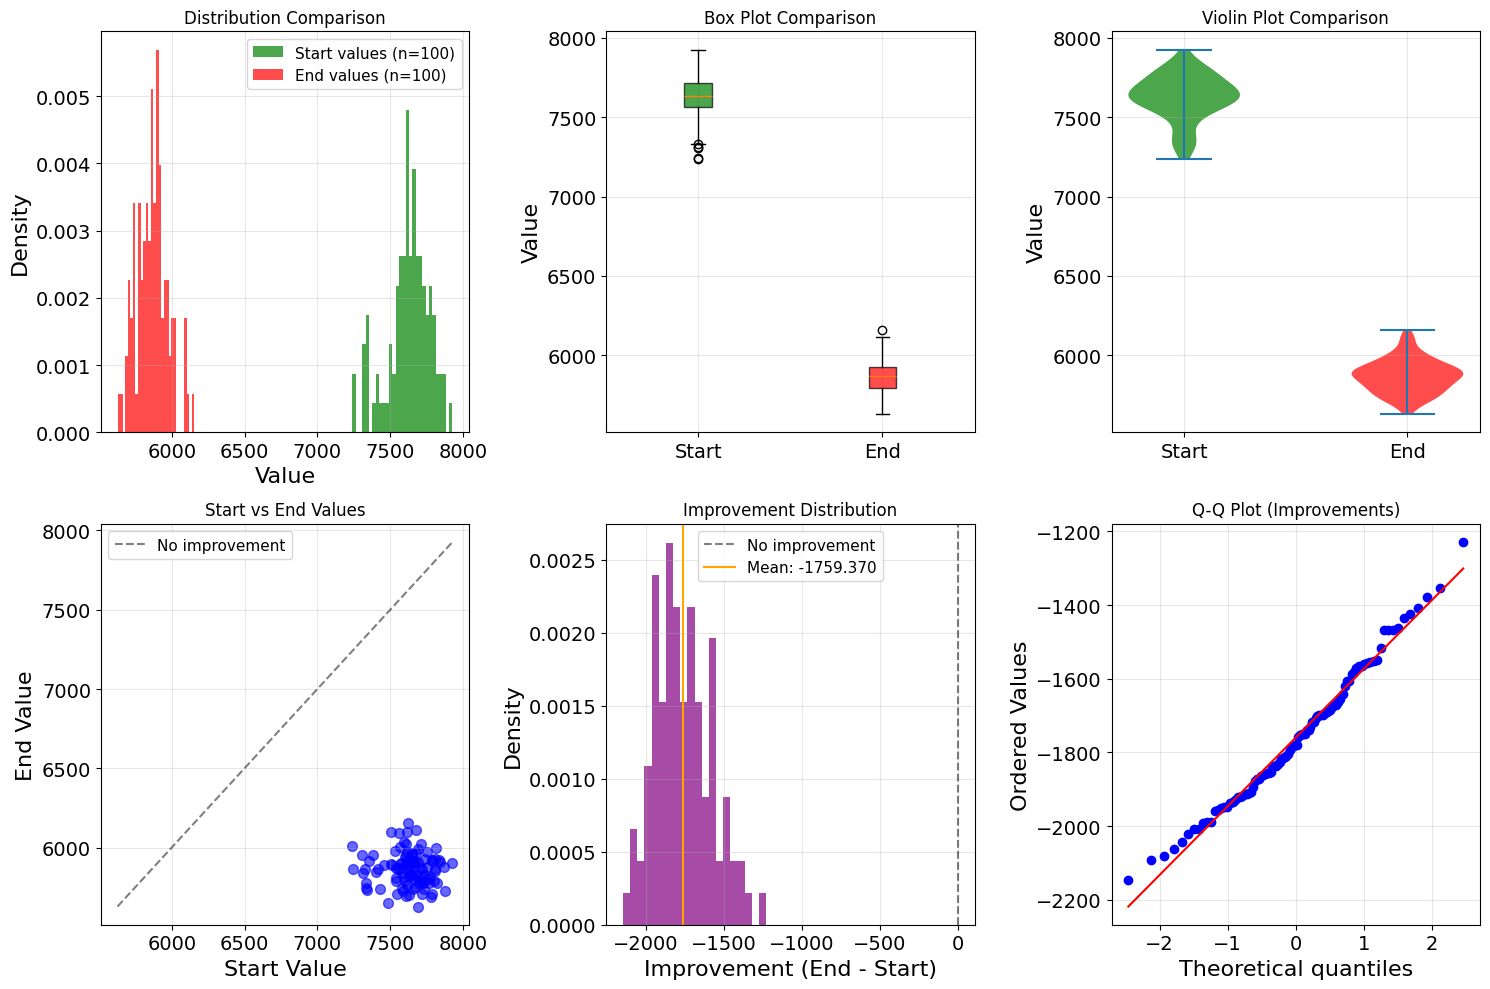

In [20]:
plot_start_end_distribution(results['start_values'], results['end_values'])

Processing 100 folders...
  Processed 10/100 folders (10 successful)
  Processed 20/100 folders (20 successful)
  Processed 30/100 folders (30 successful)
  Processed 40/100 folders (40 successful)
  Processed 50/100 folders (50 successful)
  Processed 60/100 folders (60 successful)
  Processed 70/100 folders (70 successful)
  Processed 80/100 folders (80 successful)
  Processed 90/100 folders (90 successful)
  Processed 100/100 folders (100 successful)

=== Extraction Summary ===
Total folders found: 100
Successfully loaded: 100
Failed to load: 0

Data Summary:
Start values range: 7543.00 - 8077.00
End values range: 5820.00 - 6285.00
Absolute bests range: 5737.00 - 6229.00
Runs that improved: 100/100 (100.0%)
Average improvement: -1738.96
=== DISTRIBUTION SUMMARY ===

Start Values:
  Mean: 7837.9400
  Std:  124.3379
  Min:  7543.0000
  Max:  8077.0000

End Values:
  Mean: 6098.9800
  Std:  80.8432
  Min:  5820.0000
  Max:  6285.0000

Improvements (End - Start):
  Mean: -1738.9600
  St

/var/folders/fj/pymmx6_53ksdnv6l4vhkxl5r0000gn/T/ipykernel_35729/4254484107.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_to_plot, labels=labels, patch_artist=True)


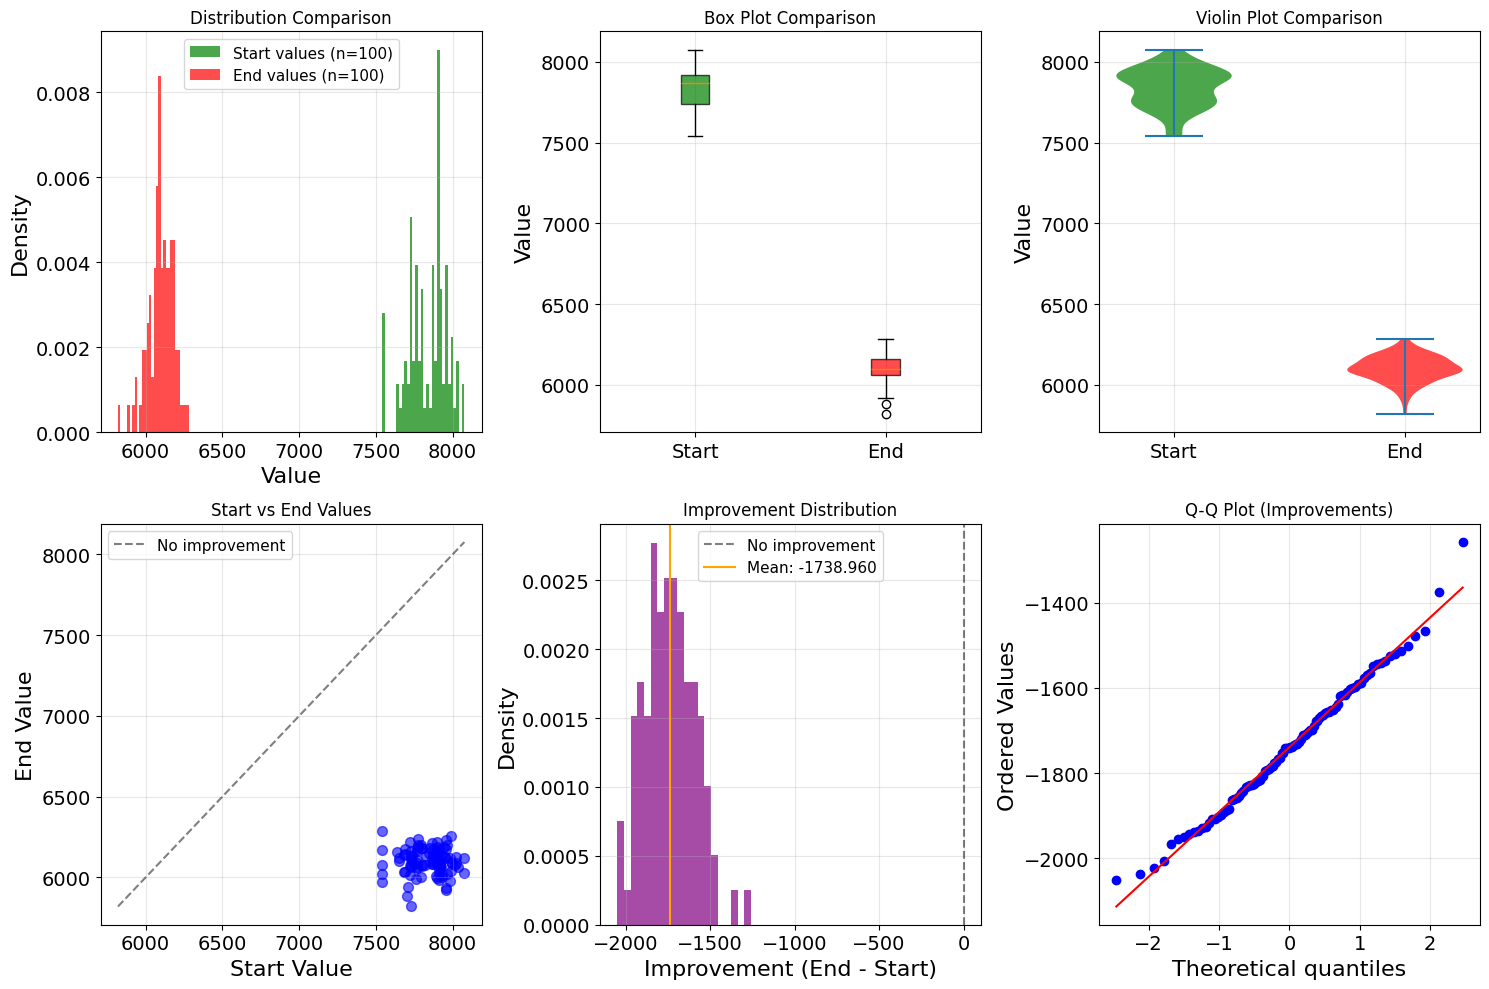

In [21]:
#ACO MC LeNet 1k
BASE_DIR = "../data/ACO_run_array_LeNet_1k_MC" 
NAME_DIR = "ACO_LeNet4"
results = extract_start_end_values(BASE_DIR, NAME_DIR, 1000)
plot_start_end_distribution(results['start_values'], results['end_values'])